<a href="https://colab.research.google.com/github/gopal2812/convandgpt/blob/main/Submission10/ERAV1_CIFAR10_Custom_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 10

## Cloning the repo

In [1]:
!rm -rf /content/convandgpt/
!git clone https://github.com/gopal2812/convandgpt.git
import os
os.chdir("/content/convandgpt/Submission10")
!pwd;ls


Cloning into 'convandgpt'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 288 (delta 49), reused 1 (delta 1), pack-reused 171
Receiving objects: 100% (288/288), 1.41 MiB | 5.18 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/convandgpt/Submission10
model  utils


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [2]:
!pip install torchmetrics
!pip install torch_lr_finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from model.customesnet import CustomResNet
from utils.util import train, test
import torch.nn.functional as F
from torchsummary import summary

# Model Initialization & Summary

In [5]:
SEED = 1
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# CUDA?
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)
model = CustomResNet(dropout_percentage=0.05, norm="bn")
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Dataset & Dataloaders

In [6]:
from utils.transforms import train_transforms, test_transforms

In [7]:
from utils.dataset import get_dataloaders

batch_size = 512
CLASSES = ("Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}
train_loader, test_loader = get_dataloaders(train_transforms=train_transforms, test_transforms=test_transforms, **kwargs)

100%|██████████| 170498071/170498071 [00:10<00:00, 15609381.13it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Exploration

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


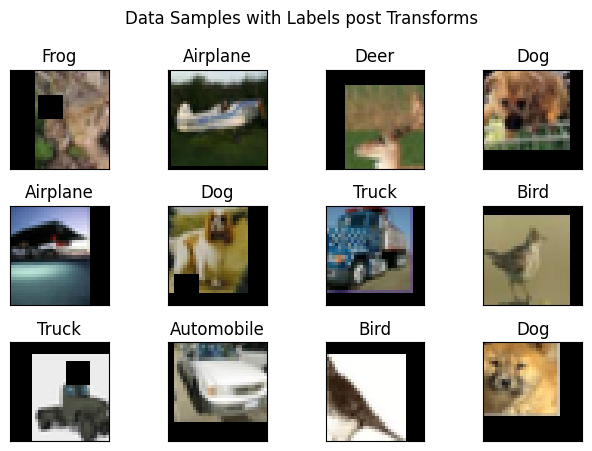

In [8]:
from utils.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=CLASSES)
plot_data_samples(train_loader, classes=CLASSES)

# Training

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.00E-03


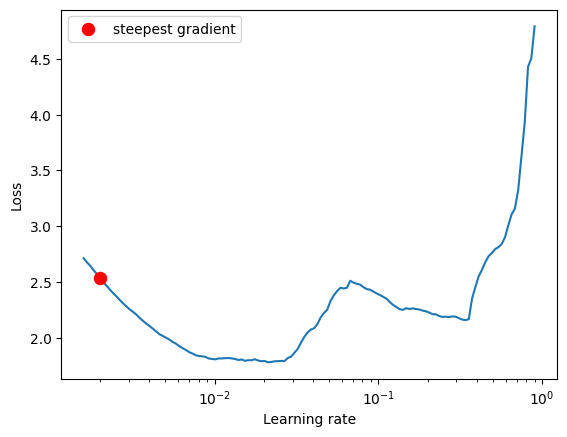

In [9]:
from torch_lr_finder import LRFinder
model = CustomResNet(dropout_percentage=0.02, norm="bn").to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = F.cross_entropy

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=2.00E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_accs)
  test_accs, test_losses = test(model, device, test_loader, criterion, test_losses, test_accs)

Epoch 1
Train: 100% Loss=1.3800 Batch_id=97 Accuracy=36.65
Test set: Average loss: 1.4536, Accuracy: 4877/10000 (48.77%)

Epoch 2
Train: 100% Loss=0.8755 Batch_id=97 Accuracy=60.40
Test set: Average loss: 1.1007, Accuracy: 6248/10000 (62.48%)

Epoch 3
Train: 100% Loss=0.7879 Batch_id=97 Accuracy=70.89
Test set: Average loss: 0.8401, Accuracy: 7208/10000 (72.08%)

Epoch 4
Train: 100% Loss=0.7300 Batch_id=97 Accuracy=75.84
Test set: Average loss: 0.7401, Accuracy: 7570/10000 (75.70%)

Epoch 5
Train: 100% Loss=0.5914 Batch_id=97 Accuracy=78.51
Test set: Average loss: 0.7848, Accuracy: 7499/10000 (74.99%)

Epoch 6
Train: 100% Loss=0.4339 Batch_id=97 Accuracy=80.93
Test set: Average loss: 0.5935, Accuracy: 7999/10000 (79.99%)

Epoch 7
Train: 100% Loss=0.4903 Batch_id=97 Accuracy=83.79
Test set: Average loss: 0.4936, Accuracy: 8330/10000 (83.30%)

Epoch 8
Train: 100% Loss=0.3822 Batch_id=97 Accuracy=85.25
Test set: Average loss: 0.6265, Accuracy: 8061/10000 (80.61%)

Epoch 9
Train: 100% Loss

In [11]:
import pandas as pd
bn_df = pd.DataFrame({'Train Acc': train_accs, 'Test Acc': test_accs, 'Train Loss': train_losses, 'Test Loss': test_losses})
bn_df.to_csv('training_stats.csv', index=False)

In [12]:
import pandas as pd
bn_train = pd.read_csv("training_stats.csv")
bn_train
train_accs = bn_train['Train Acc'].tolist()
test_accs = bn_train['Test Acc'].tolist()
train_losses = bn_train['Train Loss'].tolist()
test_losses = bn_train['Test Loss'].tolist()

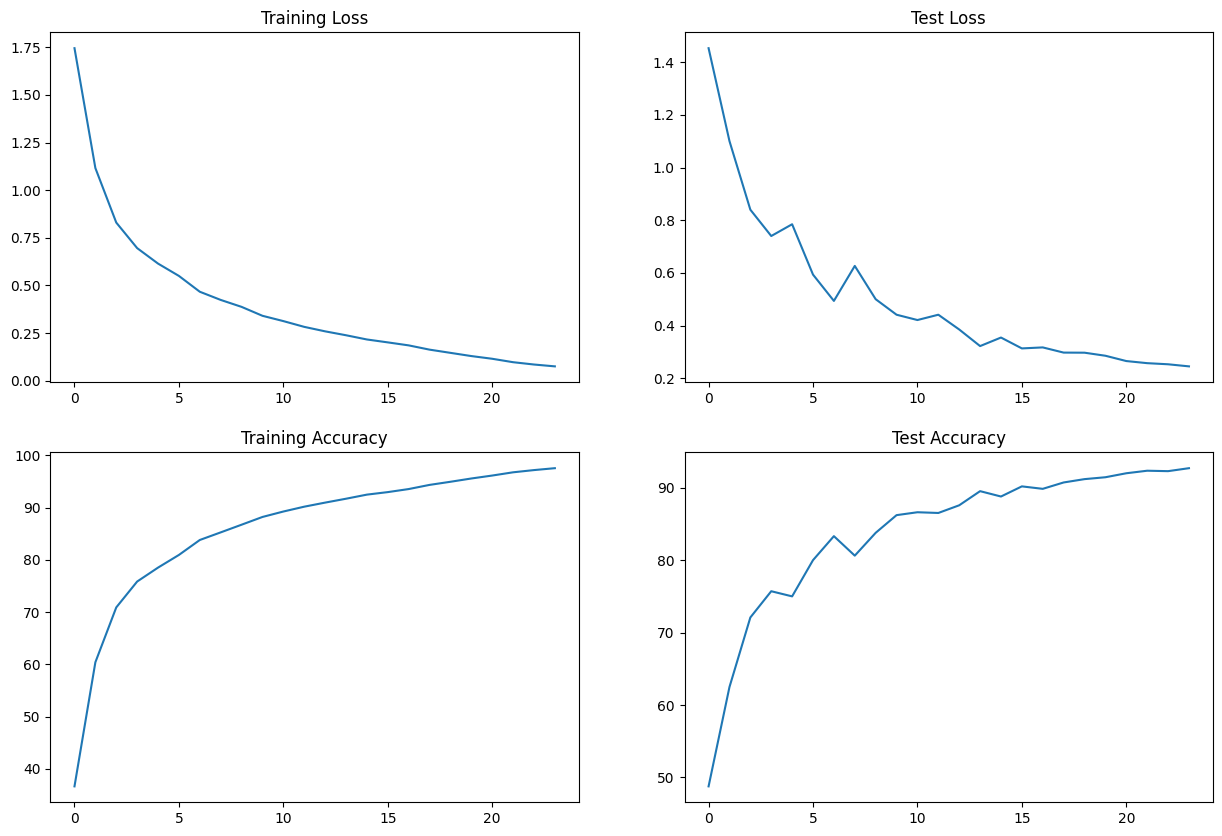

In [13]:
from utils.visualize import plot_model_training_curves

plot_model_training_curves(train_accs=train_accs, test_accs=test_accs, train_losses=train_losses, test_losses=test_losses)

# Model Analysis

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


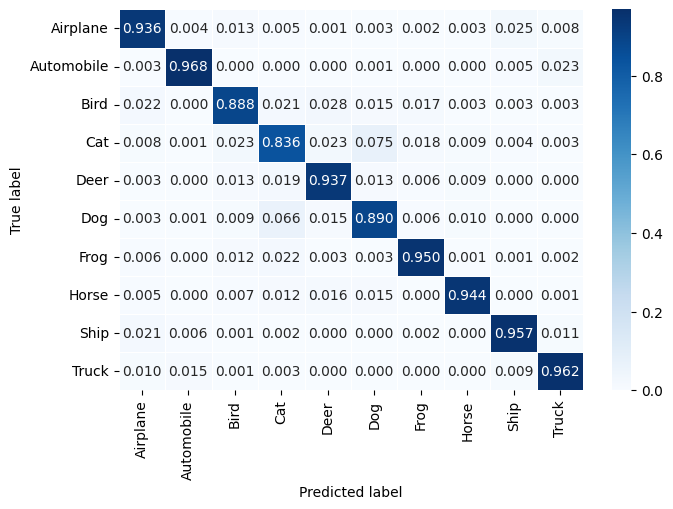

In [14]:
from utils.util import get_all_and_incorrect_preds
from utils.visualize import plot_confusion_matrix

all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model=model, loader=test_loader, device=device)
plot_confusion_matrix(all_labels, all_preds, classes=CLASSES)

Total Incorrect Predictions 732


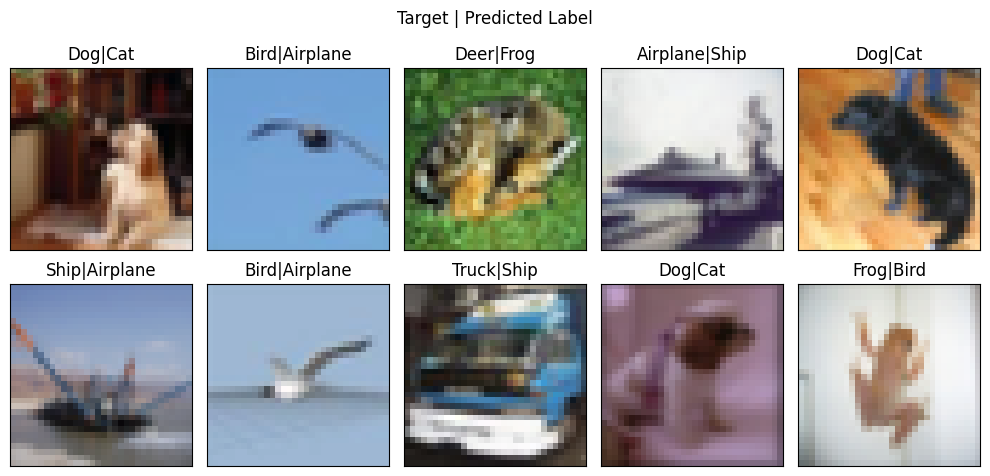

In [15]:
from utils.visualize import plot_incorrect_preds

plot_incorrect_preds(incorrect, classes=CLASSES)

In [16]:
from google.colab import files
files.download('training_stats.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>